<a href="https://colab.research.google.com/github/lleviraz/urban_segmentation/blob/main/notebooks/Exporting_S2_Batch_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>Google Earth Engine Image Export </h1>

## Connecting GEE with Google Services

**Note** that the earthengine-api is `'beta'`!!!

**Authenticate to Earth Engine**

In [ ]:
#earth-engine Python API
!pip install earthengine-api --upgrade -q
!pip install rasterio -q

In [ ]:
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
import os
import ee
ee.__version__

'0.1.309'

In [ ]:
!earthengine authenticate 

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=VrcV35XgoJqzidhzCPrfYaG4n2a7Hdxy5OGzrWYpAkI&tc=GbTARvnK7_lCjaEzC6W6HkF-WdM9_2FXEpSWabD1QOs&cc=ivpp2egUkqUMhmUSY8lRCVZFBk3cS41Rk8_2uFnGXHE

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhB-M86BHQrU-f4EXawCttC31P_pLLincIGszSuOsbIy4VozT3SW2c

Successfully saved authorization token.


- **Authenticate to Google Drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initiate the API

In [ ]:
# Earth Engine Python API
ee.Initialize()

# Yoav's Converted Code (using geemap)


In [ ]:
#For converting the GEE JS to Python 
# !pip install geemap -q

In [ ]:

# import geemap

In [ ]:
# from geemap.conversion import *

# Create a temporary working directory
# work_dir = os.path.join(os.path.expanduser('~'), 'geemap')
# Get Earth Engine JavaScript examples. There are five examples in the geemap package folder.
# Change js_dir to your own folder containing your Earth Engine JavaScripts,
# such as js_dir = '/path/to/your/js/folder'
# js_dir = '/content/'#get_js_examples(out_dir=work_dir)

# Convert all Earth Engine JavaScripts in a folder recursively to Python scripts.
# js_to_python_dir(in_dir=js_dir, out_dir=js_dir, use_qgis=True)
# print("Python scripts saved at: {}".format(js_dir))

In [ ]:
def doExport2(dataset,region,img_ID,block=True):
  """Runs the image export task.  Block until complete."""
  task = ee.batch.Export.image.toDrive(**{
    'image': dataset.mean(),
    'description': 'Export_S2_Image',
    'scale': 10,
    'region': region,
    'fileNamePrefix':'s2_img_'+str(img_ID),
    'folder':'gee_export',
    'crs':'EPSG:3857'
    }
  )
  task.start()

  if(block):
    print('Exporting image to Drive...')
    # Block until the task completes.
    import time
    while task.active():
      time.sleep(5)
      # print('Polling for task (id: {}).'.format(task.id))

    # Error condition
    if task.status()['state'] != 'COMPLETED':
      print('Error with image export.')
    else:
      print('Image export completed.')
  else:
    # print('Started background export of image to Drive...')
    return task

In [ ]:
import ee 
# from ee.ee_ import Map 
# The Training_grid was prepared by Yoav (HOW? GIS ? )
table = ee.FeatureCollection("users/yoavpld/ML/Training_grid")

fc = ee.FeatureCollection(table)

def maskS2clouds(image):
  qa = image.select('QA60')
  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000)

BANDS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
print(len(BANDS),' bands selected')

dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
                  .filterDate('2019-01-01', '2020-01-30') \
                  .map(lambda x: x.clip(table)) \
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',1)) \
                  .map(maskS2clouds)
dataset = dataset.select(BANDS)

visualization = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2'],
}

#n_list = ee.List(ee.Feature(table))
#print(n_list)

ee.mapclient.addToMap(dataset.mean(), visualization, 'RGB')

# ee.mapclient.addToMap(fc, {}, 'Grid')

# IDlist = table.aggregate_array('ID')
# IDlist = []
# for f in table.getInfo()['features']:
#   id= f['properties']['ID']
#   IDlist.append(ee.Number(id))
# print(IDlist)

# def loop(IDlist):
#   return ee.Number(IDlist)

# fc1 = ee.FeatureCollection(fc)#.filter(ee.Filter.eq('ID', '66'))

11  bands selected


In [ ]:
for fff in table.getInfo()['features']:
  if(fff['properties']['ID']==184):
    print(fff)

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[9.470965704826419, 51.27932485866085], [9.49791645869669, 51.27932485896577], [9.49791645585195, 51.29618015832744], [9.470965674537378, 51.29618010800738], [9.470965704826419, 51.27932485866085]]]}, 'id': '000000000000000000b8', 'properties': {'ID': 184, 'R': 0.25}}


In [ ]:
for fff in table.getInfo()['features']:
  if(fff['properties']['ID']==204):
    print(fff)


{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-3.2222266452083757, 51.447591094208555], [-3.195280302163699, 51.44759108131557], [-3.1952803432220866, 51.46438454619946], [-3.2222267028979883, 51.46438460475225], [-3.2222266452083757, 51.447591094208555]]]}, 'id': '000000000000000000cc', 'properties': {'ID': 204, 'R': 0.25}}


In [ ]:
%%time

tasks = []
# SELECTED = [204]#,480,689,185,528,218,215,509,388,640,543,424,433]
from tqdm.notebook import tqdm
print('Exporting images (background)...')
for img in tqdm(fc.getInfo()['features']):#[:5]):
  img_id = img['properties']['ID']
  # if img_id in SELECTED:
  print('img:',img_id,end=' ')
  fc11 = ee.Geometry.Polygon(img['geometry']['coordinates'])
  tasks.append(doExport2(dataset,fc11,img_id,block=False))

Exporting images (background)...


  0%|          | 0/700 [00:00<?, ?it/s]

img: 204 CPU times: user 154 ms, sys: 4.94 ms, total: 159 ms
Wall time: 610 ms


In [ ]:
#Sequential export of images
# %%time

# from tqdm.notebook import tqdm
# for img in tqdm(fc.getInfo()['features'][:15]):
#   img_id = img['properties']['ID']
#   print('image:',img_id)
#   fc11 = ee.Geometry.Polygon(img['geometry']['coordinates'])
#   doExport2(dataset,fc11,img_id)

## 700 images take ~2 hours with the free account

In [ ]:
%%time

import time
errs=0
for task in tqdm(tasks):
  while task.active():
    time.sleep(5)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    errs+=1
    print('Error with image export.')
  else:
    # print('Image export completed.')
    pass

print('{} images exported, {} failed.)'.format(len(tasks)-errs,errs))

  0%|          | 0/1 [00:00<?, ?it/s]

1 images exported, 0 failed.)
CPU times: user 119 ms, sys: 14.3 ms, total: 133 ms
Wall time: 10.5 s


In [ ]:
import os
from pathlib import Path

path = Path('/content/drive/MyDrive/gee_export/')
files = [f for f in path.iterdir()]
files[:3]

[PosixPath('/content/drive/MyDrive/gee_export/s2_img_66.tif'),
 PosixPath('/content/drive/MyDrive/gee_export/s2_img_74.tif'),
 PosixPath('/content/drive/MyDrive/gee_export/s2_img_90.tif')]

In [ ]:
SAMPLE_IMAGE = Path(files[0])

In [ ]:
def normalize(image,vmin=0.0,vmax=0.3):
  '''
  RGB data was exported in the range between 0 and 0.3
  '''
  return (image - vmin)/(vmax-vmin)

def display_image(image_path,bands=[3,2,1],title=None,ax=None,vmin=0.0,vmax=0.3):
  '''
  Displaying RBG images by Red,Green,Blue in this order
  '''
  img =  rio.open(image_path)
  show(normalize(img.read(bands),vmin=vmin,vmax=vmax), title=title,ax=ax)
  # print(title,len(img.indexes),'bands')
  return img

In [ ]:
def print_image_metadata(rasterio_img,title=None):
  print(title + ' Metadata:',rasterio_img.meta)
  print(title + ' Transform:\n',rasterio_img.transform)

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


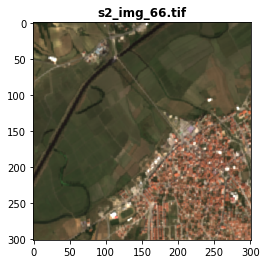

/content/drive/MyDrive/gee_export/s2_img_66.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 301, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 2968300.0,
       0.0, -10.0, 5053860.0)}
/content/drive/MyDrive/gee_export/s2_img_66.tif Transform:
 | 10.00, 0.00, 2968300.00|
| 0.00,-10.00, 5053860.00|
| 0.00, 0.00, 1.00|


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


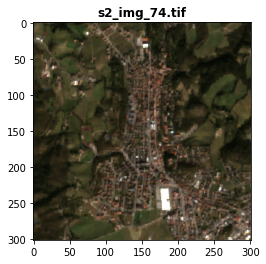

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/MyDrive/gee_export/s2_img_74.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 301, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 1204300.0,
       0.0, -10.0, 5518860.0)}
/content/drive/MyDrive/gee_export/s2_img_74.tif Transform:
 | 10.00, 0.00, 1204300.00|
| 0.00,-10.00, 5518860.00|
| 0.00, 0.00, 1.00|


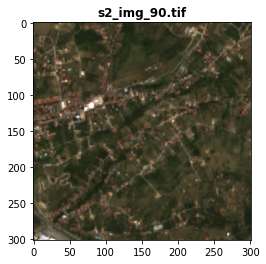

/content/drive/MyDrive/gee_export/s2_img_90.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 301, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 2443300.0,
       0.0, -10.0, 5953860.0)}
/content/drive/MyDrive/gee_export/s2_img_90.tif Transform:
 | 10.00, 0.00, 2443300.00|
| 0.00,-10.00, 5953860.00|
| 0.00, 0.00, 1.00|


In [ ]:
import matplotlib.pyplot as plt

for i,f in tqdm(enumerate(files[:3])):
  img1=display_image(f,title=f.name)
  print_image_metadata(img1,img1.name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/MyDrive/gee_export/s2_img_184.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 301, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 1054300.0,
       0.0, -10.0, 6673860.0)}
/content/drive/MyDrive/gee_export/s2_img_184.tif Transform:
 | 10.00, 0.00, 1054300.00|
| 0.00,-10.00, 6673860.00|
| 0.00, 0.00, 1.00|
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_2_184.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 302, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 1054300.0,
       0.0, -10.0, 6673861.282476528)}
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_2_184.tif Transform:
 | 10.00, 0.00, 1054300.00|
| 0.00,-10.00, 6673861.28|
| 0.00, 0.00, 1.00|


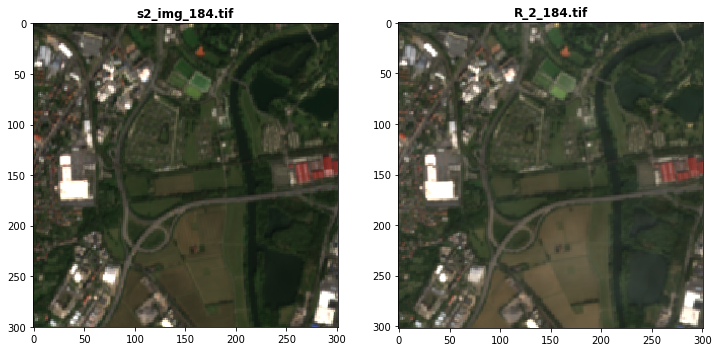

In [ ]:
f,axs=plt.subplots(1,2,figsize=(12,30))
NEW_IMG = Path('/content/drive/MyDrive/gee_export/s2_img_184.tif')
REF_IMAGE = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_2_184.tif')

img0=display_image(NEW_IMG,title=NEW_IMG.name,ax=axs[0])
print_image_metadata(img0,img0.name)
print('===============================')
img2=display_image(REF_IMAGE,title=REF_IMAGE.name,ax=axs[1])
print_image_metadata(img2,img2.name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/MyDrive/gee_export/s2_img_204.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 301, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, -358700.0,
       0.0, -10.0, 6703860.0)}
/content/drive/MyDrive/gee_export/s2_img_204.tif Transform:
 | 10.00, 0.00,-358700.00|
| 0.00,-10.00, 6703860.00|
| 0.00, 0.00, 1.00|
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_3_204.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 301, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, -358700.0,
       0.0, -10.0, 6703854.207184071)}
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_3_204.tif Transform:
 | 10.00, 0.00,-358700.00|
| 0.00,-10.00, 6703854.21|
| 0.00, 0.00, 1.00|


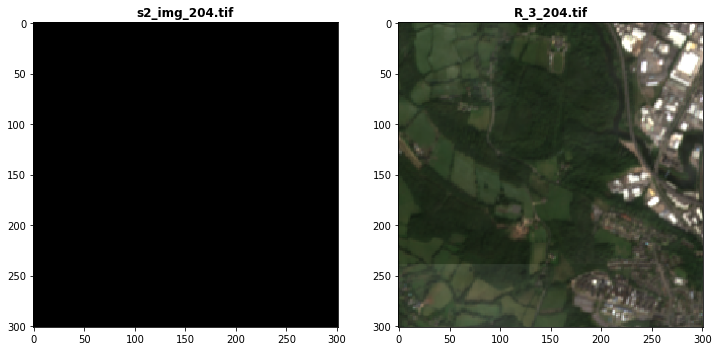

In [ ]:
f,axs=plt.subplots(1,2,figsize=(12,6))
NEW_IMG = Path('/content/drive/MyDrive/gee_export/s2_img_204.tif')
REF_IMAGE = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_3_204.tif')

img0=display_image(NEW_IMG,title=NEW_IMG.name,ax=axs[0])
print_image_metadata(img0,img0.name)
print('===============================')
img2=display_image(REF_IMAGE,title=REF_IMAGE.name,ax=axs[1])
print_image_metadata(img2,img2.name)

In [ ]:
# NUM_BANDS = 11

# bands_dictionary = {
#     1:'B1_Blue',
#     2:'B2_Green',
#     3:'B3_Red',
#     4:'B4_Red_Edge_1',
#     5:'B5_Red_Edge_2',
#     6:'B6_Red_Edge_3',
#     7:'B7_NIR',
#     8:'B8_Red_Edge_4',
#     9:'B9_Water_vapor',
#     10:'B10_SWIR_1',
#     11:'B11_SWIR_2'
# }
# for cm in ['cividis_r']:
#   f, axes = plt.subplots(1,img0.count,figsize=(20,4))
#   for i in range(1,img0.count+1):
#     # show(normalize(s2_sample.read(i)), ax=axes[i-1], title=bands_dictionary[i],cmap=cm)
#     show(img0.read(i), ax=axes[i-1], title=bands_dictionary[i],cmap=cm)
#     # plt.suptitle(cm)
#   plt.show()

In [ ]:
# MAX_LEN=10
# f,axs=plt.subplots(int(len(files)/MAX_LEN),MAX_LEN,figsize=(100,70))
# row=0
# col=0
# for img_nm in tqdm(files[:3]):
#   img = Path(img_nm)
#   # display_image(img,title=img.name,ax=axs[row,col])
#   print(img.read())
#   # print(row,col)
#   if(col<MAX_LEN-1):
#     col+=1
#   else:
#     row+=1
#     col=0

In [ ]:
import glob as glob
list_of_files = filter( os.path.isfile,
                        glob.glob('/content/drive/MyDrive/gee_export/*.tif', recursive=True) )
# Sort list of files in directory by size 
list_of_files = sorted( list_of_files,
                        key =  lambda x: os.stat(x).st_size)


In [ ]:
print('nan exported files (size 29KB):')
for file in list_of_files[:30]:
  fsize=os.stat(file).st_size
  if(fsize==29262):
    print(file,fsize)

nan exported files (size 29KB):
/content/drive/MyDrive/gee_export/s2_img_480.tif 29262
/content/drive/MyDrive/gee_export/s2_img_689.tif 29262
/content/drive/MyDrive/gee_export/s2_img_185.tif 29262
/content/drive/MyDrive/gee_export/s2_img_528.tif 29262
/content/drive/MyDrive/gee_export/s2_img_218.tif 29262
/content/drive/MyDrive/gee_export/s2_img_215.tif 29262
/content/drive/MyDrive/gee_export/s2_img_509.tif 29262
/content/drive/MyDrive/gee_export/s2_img_388.tif 29262
/content/drive/MyDrive/gee_export/s2_img_640.tif 29262
/content/drive/MyDrive/gee_export/s2_img_543.tif 29262
/content/drive/MyDrive/gee_export/s2_img_424.tif 29262
/content/drive/MyDrive/gee_export/s2_img_433.tif 29262
/content/drive/MyDrive/gee_export/s2_img_204.tif 29262


In [ ]:
import numpy as np
np.array(img0.read(1))


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
///\\\ STOP NB HERE///\\\

SyntaxError: ignored

# Original NB code

## Define area of interest


In [ ]:
# Define a point in the area where we want to acquire an image (Des Moines, Iowa)
area_of_interest = ee.Geometry.Point(-93.6765557, 41.5666487)

## Filter and select a tile that overlaps with the area of interest

In [ ]:
tile = ee.ImageCollection('COPERNICUS/S2_SR')\
.filterBounds(area_of_interest)\
.filterDate('2020-01-01', '2020-12-31')\
.sort('CLOUDY_PIXEL_PERCENTAGE')\
.first()

##Select bands to get red, blue, and green frequencies

In [ ]:
rgb_tile = tile.visualize(bands = ['B4', 'B3', 'B2'], max = 4000)

## Create polygon around area of interest

In [ ]:
bounding_box = ee.Geometry.Polygon([[[-93.6529284855,41.573865262],[-93.5677844426,41.573865262],[-93.5677844426,41.6106685132],[-93.6529284855,41.6106685132],[-93.6529284855,41.573865262]]])

##Export to drive:
1. Specify the Sentinel tile, which we already defined
2. Name your export
3. Specify the folder where you want to store your export
4. Set the scale of the export
5. Specify the region we want to export (note: this can be any polygon, but in this case we use a rectangular box)
6. Set the desired output CRS
7. Set the desired output filetype

In [ ]:
task = ee.batch.Export.image.toDrive(**{
'image': rgb_tile,
'description': 'test_export',
'folder':'ee_images',
'scale': 5,
'region': bounding_box.getInfo()['coordinates'],
'crs':'EPSG:4326',
'fileFormat':'GeoTIFF',
})
task.start()

In [ ]:
import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

Yoav's Export Code
